### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, ADASYN
from keras.utils.np_utils import to_categorical

### Import Data

In [2]:
train_df = pd.read_csv('mitbih_train.csv',header=None)
test_df = pd.read_csv('mitbih_test.csv',header=None)

In [3]:
train_df[187]=train_df[187].astype(int)
overview=train_df[187].value_counts()
print(overview)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


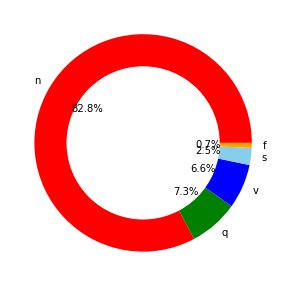

In [4]:
original=train_df[187].value_counts()
plt.figure(figsize=(10,5))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(original, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Oversampling

In [5]:
n_samples = max(overview)

df_0=train_df[train_df[187]==0]
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]

#### Random Oversampling

In [6]:
df_1_upsample=resample(df_1,replace=True,n_samples=n_samples,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=n_samples,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=n_samples,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=n_samples,random_state=126)

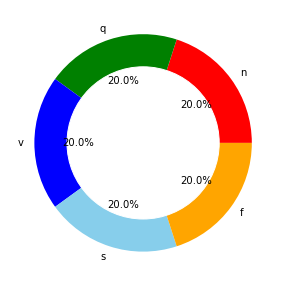

In [7]:
train_up=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])
X_up, y_up = train_up.iloc[:,:-1].values, train_up.iloc[:,-1].values

#### Oversampling Methods

In [10]:
def oversample(func, df, cluster_balance_threshold=None):
    if cluster_balance_threshold:
        method = func(cluster_balance_threshold=cluster_balance_threshold)
    else:
        method = func()
    X = df.iloc[:,:-1].values
    y = df.iloc[:,-1].values
    X, y = method.fit_resample(X,y)
    return X, y

In [11]:
# Generating Different Training Sets
X_smote, y_smote = oversample(SMOTE, train_df)
X_bord, y_bord = oversample(BorderlineSMOTE, train_df)
X_ada, y_ada = oversample(ADASYN, train_df)
X_km, y_km = oversample(KMeansSMOTE, train_df, 0.01)

### CNN Multiclass Classification

In [13]:
# helper function to tensor
def transform(X,y):
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = to_categorical(y)
    return X, y

#### CNN 

In [14]:
import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [49]:
def network(X_train,y_train,X_test,y_test,name='np'):
    
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='f{name}.h5', monitor='val_loss', save_best_only=True)]

    history = model.fit(X_train, y_train, epochs=30, callbacks=callbacks, 
                      batch_size=32,validation_data=(X_test,y_test))
    
    model.load_weights('f{name}.h5')
    
    return (model,history)

### Metrics

#### Confusion Matrix 

In [17]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import itertools

In [117]:
# put source of code, towardsdatascience

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
# 1. definitions 
# 2. Paper Source

In [20]:
def TP(i, pred_y): # i denotes class 
    #predicted as i class and true=i
    true_y = test_df.iloc[:,-1].values
    n = len(pred_y)
    score=0
    for j in range(n):
        if pred_y[j]==i and true_y[j]==i:
            score+=1   
    return score

In [21]:
def FP(i, pred_y): # i denotes class 
    #predicted as i class but true!=i
    true_y = test_df.iloc[:,-1].values
    n = len(pred_y)
    score=0
    for j in range(n):
        if pred_y[j]==i and true_y[j]!=i:
            score+=1
    return score

In [22]:
def TN(i, pred_y): # i denotes class 
    #predicted as non-i class and made pred=true
    true_y = test_df.iloc[:,-1].values
    n = len(pred_y)
    score=0
    for j in range(n):
        if pred_y[j]!=i and true_y[j]==pred_y[j]:
            score+=1       
    return score

In [23]:
def FN(i, pred_y): # i denotes class 
    #predicted as non-i class but true=i
    true_y = test_df.iloc[:,-1].values
    n = len(pred_y)
    score=0
    for j in range(n):
        if pred_y[j]!=i and true_y[j]==i:
            score+=1     
    return score

In [24]:
def precision(i,pred_y):
    return TP(i,pred_y)/(TP(i,pred_y)+FP(i,pred_y))

def recall(i,pred_y):
    return TP(i,pred_y)/(TP(i,pred_y)+FN(i,pred_y))

def F_measure(i, pred_y):
    r = recall(i,pred_y)
    p = precision(i,pred_y)
    return 2*r*p/(r+p)

def G_mean(i, pred_y):
    r=recall(i,pred_y)
    return np.sqrt(r*( TN(i,pred_y)/(TN(i,pred_y)+FP(i,pred_y)) ))

def mGM(pred_y):
    score = 1
    for i in range(5):
        score*=recall(i,pred_y)
    return np.power(score,1/5)

def AvAccu(pred_y):
    score = 0
    for i in range(5): #num_classes
        score+=precision(i,pred_y)
    return score/5

def CBA(pred_y):
    score=0
    for i in range(5):
        score+=( TP(i,pred_y)/max(FN(i,pred_y),FP(i,pred_y)) )
    return score/5

### Evaluation

In [25]:
def evaluate(X_train, y_train, X_test, y_test,name='np'):
    model, _ = network(X_train, y_train, X_test, y_test)
    y_pred = model.predict(X_test)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                          title='Confusion matrix, with normalization')
    plt.show()
    
    return y_pred

In [26]:
X_test, y_test = transform(test_df.iloc[:,:-1].values, test_df.iloc[:,-1].values)

##### Non-processed Result

Epoch 1/30
2737/2737 [==============================] - 51s 18ms/step - loss: 0.1258 - accuracy: 0.9648 - val_loss: 0.0930 - val_accuracy: 0.9741
Epoch 2/30
2737/2737 [==============================] - 60s 22ms/step - loss: 0.0707 - accuracy: 0.9796 - val_loss: 0.0852 - val_accuracy: 0.9759
Epoch 3/30
2737/2737 [==============================] - 51s 19ms/step - loss: 0.0555 - accuracy: 0.9835 - val_loss: 0.0698 - val_accuracy: 0.9812
Epoch 4/30
2737/2737 [==============================] - 64s 23ms/step - loss: 0.0455 - accuracy: 0.9864 - val_loss: 0.0777 - val_accuracy: 0.9804
Epoch 5/30
2737/2737 [==============================] - 60s 22ms/step - loss: 0.0385 - accuracy: 0.9884 - val_loss: 0.0733 - val_accuracy: 0.9842
Epoch 6/30
2737/2737 [==============================] - 65s 24ms/step - loss: 0.0339 - accuracy: 0.9895 - val_loss: 0.0676 - val_accuracy: 0.9842
Epoch 7/30
2737/2737 [==============================] - 61s 22ms/step - loss: 0.0303 - accuracy: 0.9902 - val_loss: 0.0686 -

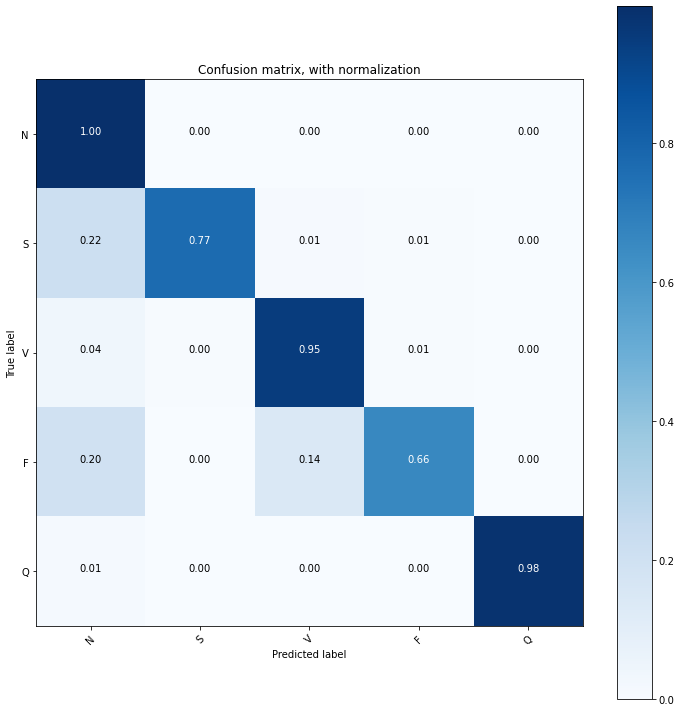

In [32]:
X_train, y_train = transform(train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values)
y_pred_np = evaluate(X_train, y_train, X_test,y_test)

##### Random Upsample Result

Epoch 1/30
11324/11324 [==============================] - 260s 23ms/step - loss: 0.0996 - accuracy: 0.9659 - val_loss: 0.1391 - val_accuracy: 0.9606
Epoch 2/30
11324/11324 [==============================] - 236s 21ms/step - loss: 0.0317 - accuracy: 0.9900 - val_loss: 0.1891 - val_accuracy: 0.9569
Epoch 3/30
11324/11324 [==============================] - 206s 18ms/step - loss: 0.0193 - accuracy: 0.9941 - val_loss: 0.1134 - val_accuracy: 0.9780
Epoch 4/30
11324/11324 [==============================] - 207s 18ms/step - loss: 0.0149 - accuracy: 0.9955 - val_loss: 0.1205 - val_accuracy: 0.9786
Epoch 5/30
11324/11324 [==============================] - 206s 18ms/step - loss: 0.0116 - accuracy: 0.9965 - val_loss: 0.1176 - val_accuracy: 0.9822
Epoch 6/30
11324/11324 [==============================] - 203s 18ms/step - loss: 0.0095 - accuracy: 0.9971 - val_loss: 0.1338 - val_accuracy: 0.9784
Epoch 7/30
11324/11324 [==============================] - 210s 19ms/step - loss: 0.0084 - accuracy: 0.9976

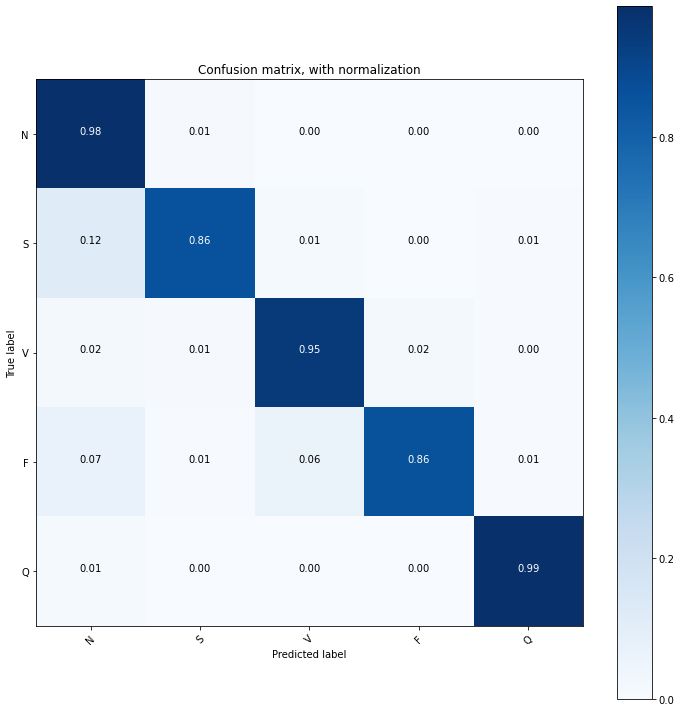

In [33]:
X_train, y_train = transform(X_up, y_up)
y_pred_up = evaluate(X_train, y_train, X_test,y_test,'up')

##### SMOTE Result

Epoch 1/30
11324/11324 [==============================] - 237s 21ms/step - loss: 0.0916 - accuracy: 0.9682 - val_loss: 0.1396 - val_accuracy: 0.9609
Epoch 2/30
11324/11324 [==============================] - 232s 20ms/step - loss: 0.0326 - accuracy: 0.9894 - val_loss: 0.1048 - val_accuracy: 0.9799
Epoch 3/30
11324/11324 [==============================] - 228s 20ms/step - loss: 0.0220 - accuracy: 0.9930 - val_loss: 0.1146 - val_accuracy: 0.9775
Epoch 4/30
11324/11324 [==============================] - 209s 18ms/step - loss: 0.0167 - accuracy: 0.9945 - val_loss: 0.1008 - val_accuracy: 0.9834
Epoch 5/30
11324/11324 [==============================] - 201s 18ms/step - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.1191 - val_accuracy: 0.9837
Epoch 6/30
11324/11324 [==============================] - 194s 17ms/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.1766 - val_accuracy: 0.9829
Epoch 7/30
11324/11324 [==============================] - 193s 17ms/step - loss: 0.0103 - accuracy: 0.9968

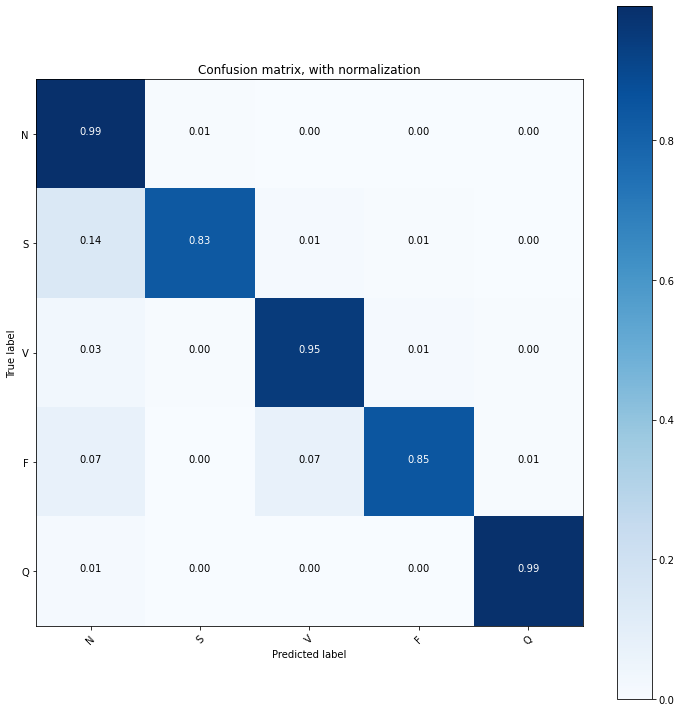

In [34]:
X_train, y_train = transform(X_smote, y_smote)
y_pred_sm = evaluate(X_train, y_train, X_test,y_test,'sm') 

##### BorderlineSMOTE Result

Epoch 1/30
11324/11324 [==============================] - 209s 18ms/step - loss: 0.0967 - accuracy: 0.9667 - val_loss: 0.1140 - val_accuracy: 0.9745
Epoch 2/30
11324/11324 [==============================] - 200s 18ms/step - loss: 0.0321 - accuracy: 0.9903 - val_loss: 0.1187 - val_accuracy: 0.9715
Epoch 3/30
11324/11324 [==============================] - 201s 18ms/step - loss: 0.0216 - accuracy: 0.9937 - val_loss: 0.1883 - val_accuracy: 0.9522
Epoch 4/30
11324/11324 [==============================] - 203s 18ms/step - loss: 0.0159 - accuracy: 0.9953 - val_loss: 0.1096 - val_accuracy: 0.9793
Epoch 5/30
11324/11324 [==============================] - 199s 18ms/step - loss: 0.0131 - accuracy: 0.9963 - val_loss: 0.1113 - val_accuracy: 0.9784
Epoch 6/30
11324/11324 [==============================] - 198s 18ms/step - loss: 0.0110 - accuracy: 0.9969 - val_loss: 0.1273 - val_accuracy: 0.9795
Epoch 7/30
11324/11324 [==============================] - 199s 18ms/step - loss: 0.0096 - accuracy: 0.9973

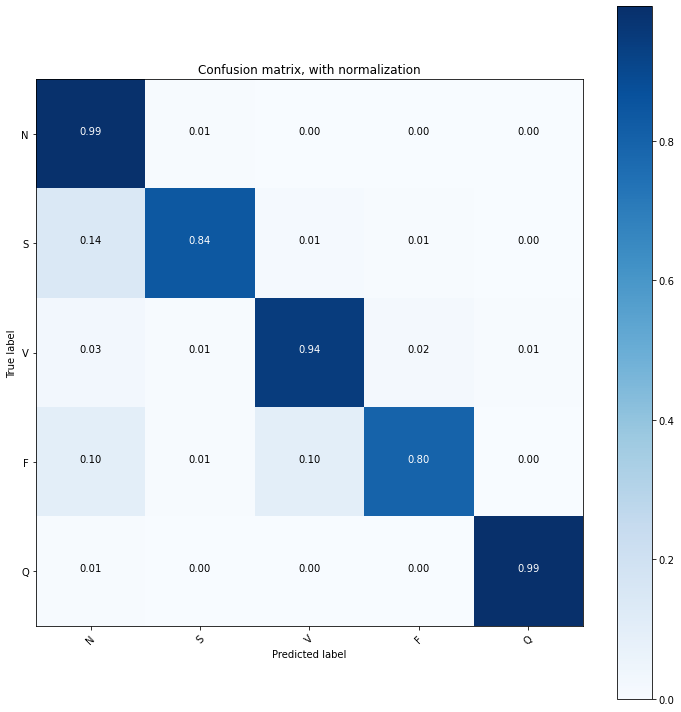

In [35]:
X_train, y_train = transform(X_bord, y_bord)
y_pred_bord = evaluate(X_train, y_train, X_test,y_test,'bord')

##### KMeansSMOTE Result

Epoch 1/30
11324/11324 [==============================] - 207s 18ms/step - loss: 0.0722 - accuracy: 0.9758 - val_loss: 0.1235 - val_accuracy: 0.9675
Epoch 2/30
11324/11324 [==============================] - 208s 18ms/step - loss: 0.0267 - accuracy: 0.9921 - val_loss: 0.0910 - val_accuracy: 0.9784
Epoch 3/30
11324/11324 [==============================] - 208s 18ms/step - loss: 0.0185 - accuracy: 0.9946 - val_loss: 0.0925 - val_accuracy: 0.9798
Epoch 4/30
11324/11324 [==============================] - 205s 18ms/step - loss: 0.0143 - accuracy: 0.9960 - val_loss: 0.1260 - val_accuracy: 0.9760
Epoch 5/30
11324/11324 [==============================] - 207s 18ms/step - loss: 0.0124 - accuracy: 0.9966 - val_loss: 0.1010 - val_accuracy: 0.9795
Epoch 6/30
11324/11324 [==============================] - 209s 18ms/step - loss: 0.0098 - accuracy: 0.9972 - val_loss: 0.1134 - val_accuracy: 0.9821
Epoch 7/30
11324/11324 [==============================] - 206s 18ms/step - loss: 0.0087 - accuracy: 0.9974

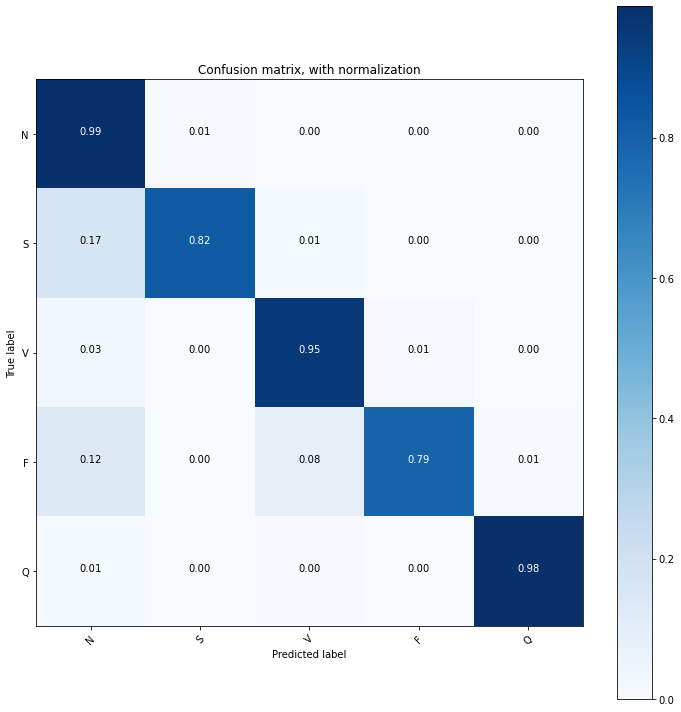

In [36]:
X_train, y_train = transform(X_km, y_km)
y_pred_km = evaluate(X_train, y_train, X_test,y_test,'km')

##### ADASYN Result

Epoch 1/30
11321/11321 [==============================] - 198s 17ms/step - loss: 0.1187 - accuracy: 0.9577 - val_loss: 0.1813 - val_accuracy: 0.9506
Epoch 2/30
11321/11321 [==============================] - 203s 18ms/step - loss: 0.0354 - accuracy: 0.9887 - val_loss: 0.1435 - val_accuracy: 0.9692
Epoch 3/30
11321/11321 [==============================] - 211s 19ms/step - loss: 0.0229 - accuracy: 0.9931 - val_loss: 0.1231 - val_accuracy: 0.9793
Epoch 4/30
11321/11321 [==============================] - 215s 19ms/step - loss: 0.0175 - accuracy: 0.9946 - val_loss: 0.1349 - val_accuracy: 0.9746
Epoch 5/30
11321/11321 [==============================] - 215s 19ms/step - loss: 0.0136 - accuracy: 0.9959 - val_loss: 0.1377 - val_accuracy: 0.9779
Epoch 6/30
11321/11321 [==============================] - 220s 19ms/step - loss: 0.0119 - accuracy: 0.9966 - val_loss: 0.1357 - val_accuracy: 0.9819
Epoch 7/30
11321/11321 [==============================] - 1843s 163ms/step - loss: 0.0101 - accuracy: 0.99

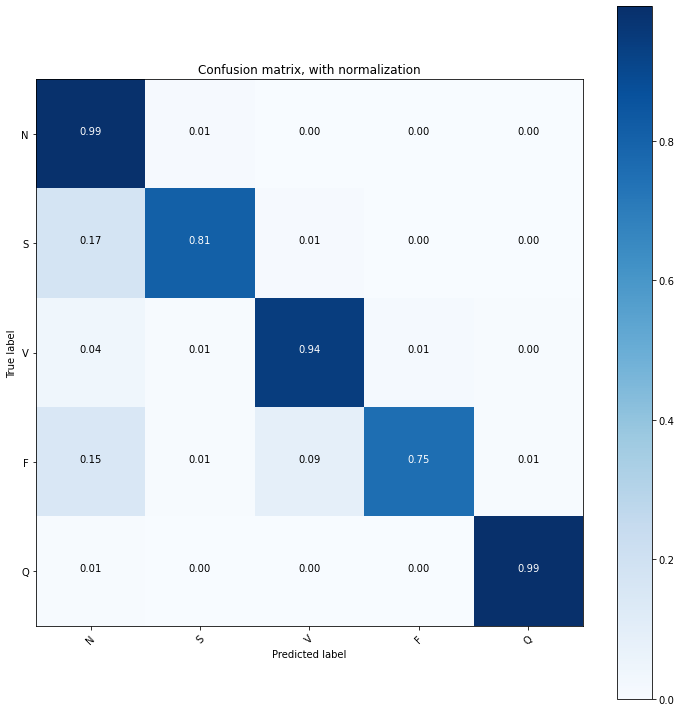

In [37]:
X_train, y_train = transform(X_ada, y_ada)
y_pred_ada = evaluate(X_train, y_train, X_test,y_test,'ada')

In [47]:
def summary(prediction, cls):
    result = prediction.argmax(axis=1)

    print("precision for group ",cls,": ", precision(cls,result))
    print("recall for group ",cls,": ", recall(cls,result))
    print("f_measure for group ",cls,": ", F_measure(cls,result))
    print("g_mean for group ",cls,": ", G_mean(cls,result))
    print('\n')
    
    return

In [95]:
# All Results in One
preds = {'original':y_pred_np,'random upsample':y_pred_up,
         'smote':y_pred_sm,'borderline smote':y_pred_bord,
         'kmeans smote':y_pred_km,'adasyn':y_pred_ada}

In [158]:
def gen_table(preds, metric_list=[precision, recall, F_measure,G_mean], cls_list=None):
    key_list = cls_list
    df_list = []
    for cls in cls_list:
        df = gen_comp_table(preds,metric_list, cls)
        df_list.append(df)
    
    res = pd.concat(df_list, axis=1, keys=key_list)
    return res

In [163]:
def gen_cls_table(preds,metric_list=[precision, recall, F_measure,G_mean],cls=None): # cls = 0, 1, .. integer value. 
    index_list = []
    data_list = []
    
    for m in metric_list:
        i,d = gen_comp_row(preds,m,cls)
        index_list.append(i)
        data_list.append(d)

    df = pd.DataFrame(data_list, index=index_list)
    
    return df

In [168]:
def gen_overall_table(preds,metric_list=[mGM,AvAccu,CBA]): # cls = 0, 1, .. integer value. 
    index_list = []
    data_list = []
    
    for m in metric_list:
        i,d = gen_comp_row(preds,m)
        index_list.append(i)
        data_list.append(d)

    df = pd.DataFrame(data_list, index=index_list)
    
    return df

In [165]:
def gen_comp_row(preds,metric,cls=None):
    index = metric.__name__
    columns = [p for p in preds]
    predictions = [preds[p] for p in preds]
    tmp = []
    
    if cls:
        for p in predictions: 
            tmp.append(metric(cls, p.argmax(axis=1)))
    else:
        for p in predictions: 
            tmp.append(metric(p.argmax(axis=1)))

    data = dict(zip(columns, tmp))
    return index, data

In [169]:
gen_overall_table(preds)

,original,random upsample,smote,borderline smote,kmeans smote,adasyn
mGM,0.860539,0.925042,0.918755,0.908087,0.901579,0.891383
AvAccu,0.944175,0.872359,0.907294,0.869446,0.885986,0.893443
CBA,33.146745,29.988534,41.954558,29.997623,30.429750,29.722202


In [101]:
df.swaplevel(0, 1, axis=1).sort_index(axis=1)

adasyn           borderline smote           kmeans smote  \
                  1         3                1         3            1   
recall     0.809353  0.753086         0.838129  0.796296     0.820144   
precision  0.738916  0.792208         0.755267  0.664948     0.737864   
F_measure  0.772532  0.772152         0.794544  0.724719     0.776831   
G_mean     0.896252  0.867155         0.912216  0.890996     0.902139   

                     original           random upsample               smote  \
                  3         1         3               1         3         1   
recall     0.790123  0.767986  0.660494        0.859712  0.858025  0.834532   
precision  0.761905  0.928261  0.849206        0.687770  0.739362  0.818342   
F_measure  0.775758  0.840551  0.743056        0.764189  0.794286  0.826358   
G_mean     0.888055  0.875664  0.812348        0.922438  0.925231  0.911302   

                     
                  3  
recall     0.845679  
precision  0.769663  
F_measure  0.805882  
G_mean     0.918728